In [1]:
# Author: Linda Karlsson, 2024

# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import seaborn as sns
import fns as fns
from pathlib import PurePath
import os
import run_ML_pipeline as rmlp
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import json
from sklearn.pipeline import Pipeline
import shap
from sklearn.model_selection import KFold
import sklearn
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.utils import resample

### Plot ML pipeline results to compare input feature block combinations and ML estimators/feature selections.

In [2]:
# Load result data

df_input1 = pd.read_csv('all_results_run1.csv') #clinical
df_input2 = pd.read_csv('all_results_run1.csv') #plasma
#df_input3 =  #MRI
#df_input4 =  #clinical+plasma
#df_input5 =  #clinical+MRI
#df_input6 =  #plasma+MRI
#df_input7 =  #clinical+plasma+MRI

# save as one list and pre-process 
all_inputs_raw = [df_input1,df_input2]
#all_inputs_raw = [df_input1,df_input2,df_input3,df_input4,df_input5,df_input6,df_input7]
all_inputs= fns.preprocess_raw_inputs(all_inputs_raw)


In [3]:
def plot_block_scores(data, title = '', save=False,savename='all_data',legend=False,ylim=(0.08,0.32),ylabel='MSE'):
    """
    Plots ML pipeline results from all_results files, comparing different input feature block combinations and coloring
    scatter points on what estimator was used.
    
    Inputs:
        - data (list): List of all_input results pre-processed with preprocess_raw_inputs.
        - title (String): plot title. Defaults to ''.
        - save (Boolean): set to true if the plot should be saved as a png file. Defaults to False.
        - savename (String): Name of saved png file. Only if save is True.
        - legend (Boolean): set to true if the plot should display a legend. Defaults to True.
        - ylim (tuple): specify the y-limit of the y-axis. Defaults to (0.08,0.32).
        - ylabel (String): set ylabel. Defaults to MSE.
        
    """
    plt.rcParams["figure.figsize"] = (10,5.5)
    plt.rc('font', size=12)
    fig, axs = plt.subplots()
    s = 5
    data2 = pd.DataFrame(columns=data[0].columns)
    for df_input in data:
        data2 = pd.concat([data2, df_input])
    sns.stripplot(data=data2, x='Input', y='Best_score',hue='Estimator',ax=axs,legend=legend,size=s,
                  dodge=False,palette=sns.color_palette("Set2"))
    axs.grid(alpha=0.2)
    plt.ylabel(ylabel)
    plt.xticks(range(0,7), ['Cli', 'Pla','MRI','Cli+Pla','Cli+MRI','Pla+MRI','Cli+Pla+MRI'])
    plt.title('All',size=16)
    plt.ylim(ylim)
    plt.title(title)
    plt.xlabel('')
    if save:
        plt.savefig(savename + '.png',bbox_inches='tight',dpi=300)

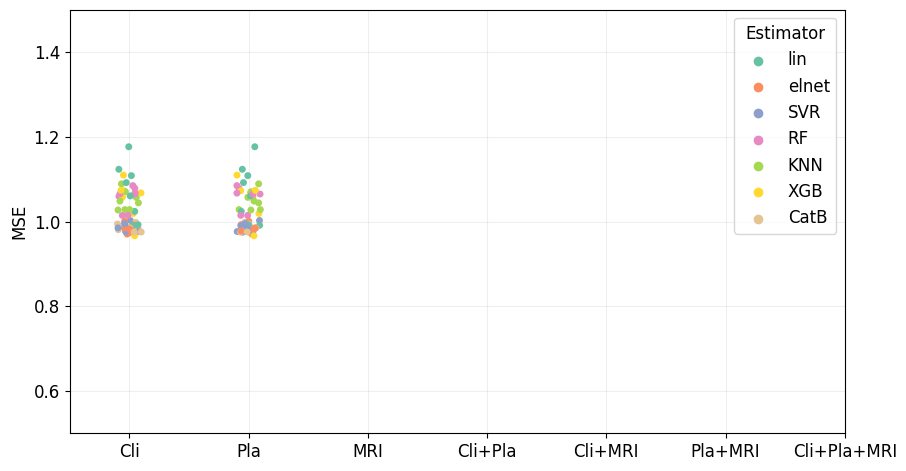

In [4]:
plot_block_scores(all_inputs,legend=True,ylim=(0.5,1.5))

### Train and plot the best ML pipeline for each input feature block in the cross-validated training set.

In [5]:
### Import training data
df = pd.read_csv('simulated_data.csv') ### INPUT DATA FILE

###Define variable input blocks
#clinical
clinical_variables = ['age', 'sex','education','mmse_score','adas_delayed_word_recall','apoe_e2', 'apoe_e4']
#plasma
plasma_variables = ['plasma_ptau217','plasma_ptau181','plasma_ptau231','plasma_NTA','plasma_GFAP','plasma_NfL'] 
#MRI
volume = [col for col in df if ((col.startswith('aseg_vol')) or (col.startswith('aparc_grayvol'))) and ('scan' not in col)]
surf_area = [col for col in df if (col.startswith('aparc_surfarea')) and ('scan' not in col)]
ct = [col for col in df if (col.startswith('aparc_ct')) and ('scan' not in col)]
MRI_variables = volume + surf_area + ct + ['samseg_wmhs_WMH_total_mm3','icv_mm3']

###Define outcome
outcome = ['tnic_cho_com_I_IV'] ## EDIT depending on what outcome you want to use

### Specifiy name of visit column and participant id
other_variables = ['Visit','sid']

### Make sure to always use the same data (remove NaNs)
variables_all = clinical_variables + plasma_variables + MRI_variables + outcome + other_variables 
df_all = df[variables_all].dropna().reset_index(drop=True)

variable_combs = [clinical_variables, plasma_variables]
#variable_combs = [clinical_variables, plasma_variables, MRI_variables,
#                  clinical_variables+plasma_variables,
#                  clinical_variables+MRI_variables,
#                  plasma_variables+MRI_variables,
#                 clinical_variables+plasma_variables+MRI_variables]

# If test set available

#df_test = pd.read_csv('')
#df_test = df_test[variables_all].dropna().reset_index(drop=True)

In [6]:
# For all input feature block combinations, train and save the best ML pipeline (10-fold-crossvalidation)
ys = []
ys_pred = []
pipes = []

for all_input,variable_comb in zip(all_inputs, variable_combs):
    y, y_pred, pipe = rmlp.get_best_CV_prediction(all_input, df_all[variable_comb + outcome + other_variables],outcome=outcome[0])
    ys.append(y)
    ys_pred.append(y_pred)
    pipes.append(pipe)
    print('Done')

Done
Done


In [ ]:
# If test set available - retrain pipeline on full training set and evaluate on test set

"""
ys_test = []
ys_pred_test = []

for pipe,variable_comb in zip(pipes, variable_combs):
    X_train = df_all[variable_comb]
    y_train = df_all[outcome[0]]
    X_test = df_test[variable_comb]
    y_test = df_test[outcome[0]]
    pipe.fit(X_train,y_train)
    y_pred_test = pipe.predict(X_test)
    ys_test.append(y_test)
    ys_pred_test.append(y_pred_test)
    print('Done')
"""

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(-2.5, 2.5)

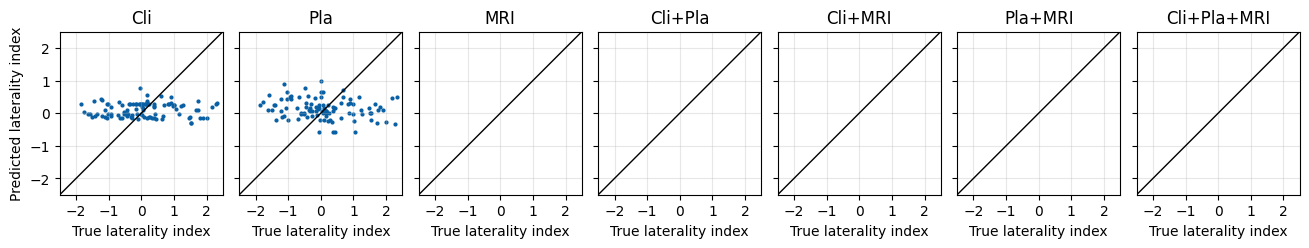

In [7]:
# Plot the predicted versus true outcome.

#set plot params and define subplot titles
plt.rcParams["figure.figsize"] = (16,4)
plt.rc('font', size=10)
fig, axs = plt.subplots(1,7, sharey=True,sharex=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)
props = dict(boxstyle='square', facecolor='white', alpha=0.5)
titles = ['Cli', 'Pla','MRI', 'Cli+Pla',
         'Cli+MRI', 'Pla+MRI','Cli+Pla+MRI']
s=4

#create data for diagonal line
x_line = np.linspace(-3,3,6)
y_line = np.linspace(-3,3,6)
                     
# plot prediction versus true data as scatter plots
for ax,y,y_pred in zip(axs.flat,ys,ys_pred):
    ax.scatter(y,y_pred,s=s,c = mpl.colormaps['GnBu'](0.9))

# adjust other plot parameters
for ax,title in zip(axs.flat,titles):
    ax.grid(alpha=0.3)
    ax.set_title(title)
    ax.plot(x_line,y_line,c='black',linewidth=1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('True laterality index')
axs[0].set_ylabel('Predicted laterality index')
axs[0].set_yticks([-2,-1,0,1, 2])
axs[0].set_xticks([-2,-1,0,1, 2])
axs[0].set_ylim([-2.5, 2.5])
axs[0].set_xlim([-2.5,2.5])

# save figure as png file.
#plt.savefig('y_scatter_asymmetry_testbf1.png',bbox_inches='tight',dpi=300)

In [8]:
def bootstrapped_score(y,y_pred1,metric=r2_score,n_iter=5000):
    """
    Evaluates a prediction metric using bootstrapping for n_iter resampled predictions.
    
    Inputs:
        - y (Series): true outcome.
        - y_pred1 (Series): predicted outcome.
        - metric (function): prediction metric. Defaults to r2_score.
        - n_iter(int): number of iterations during bootstrapping. Defaults to 5000.
        
    Outputs: 
        - array with n_iter bootstrapped scores.
    """
    scores = []
    for i in range(n_iter):
        s,s1 = resample(y,y_pred1,n_samples=len(y))
        res1 = metric(s,s1)
        scores.append(res1)
    return np.array(scores)

In [9]:
#Create confidence interval for R2-score and mean absolute error with bootstrapping.
upper = []
lower = []
upper_mae = []
lower_mae = []
for i in range(0,len(ys)):
    scores = bootstrapped_score(ys[i],ys_pred[i],metric=r2_score)
    lower.append(sorted(scores)[250]) # 5%
    upper.append(sorted(scores)[4749]) # 95%
    scores_mae = bootstrapped_score(ys[i],ys_pred[i],metric=mean_absolute_error)
    lower_mae.append(sorted(scores_mae)[250]) #5%
    upper_mae.append(sorted(scores_mae)[4749]) #95#

r2 score for input Cli: -0.03259402278408796
mean squared error for input Cli: 0.7921684176357182
r2 score for input Pla: -0.2252262801654228
mean squared error for input Pla: 0.8786157095735514


Text(0, 0.5, 'R-squared')

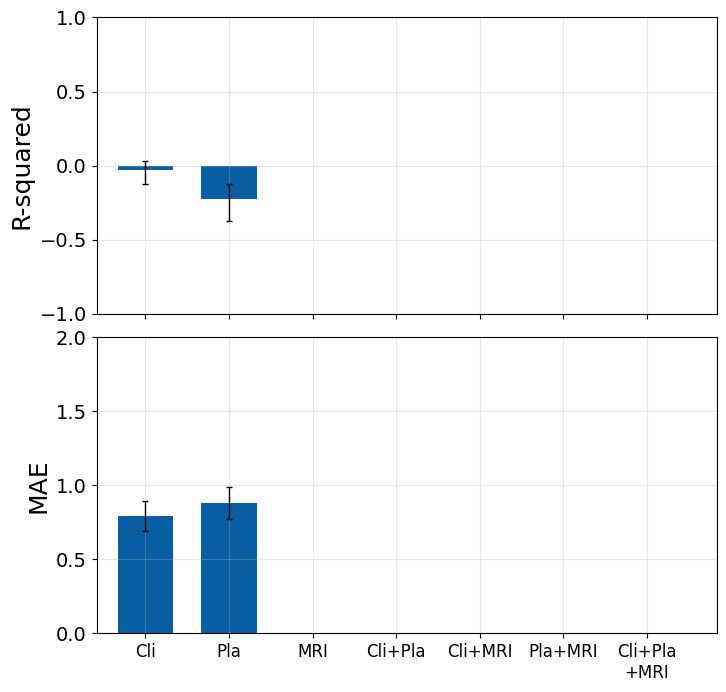

In [10]:
# Barplot and print the R2-score and mean squared error of prediction.

#set plot params and define subplot titles
plt.rcParams["figure.figsize"] = (8,8)
plt.rc('font', size=14)
fig, axs = plt.subplots(2,1,sharex=True)
plt.subplots_adjust(wspace=0.3, hspace=0.08)
props = dict(boxstyle='square', facecolor='white', alpha=0.5)
inputs = ['Cli', 'Pla','MRI', 'Cli+Pla',
         'Cli+MRI', 'Pla+MRI','Cli+Pla\n+MRI']

# plot barplots and print r2-scores and mean squared errors.
for y,y_pred,low,low_mae,upp,upp_mae,i,ipt in zip(ys, ys_pred, lower,lower_mae,upper,upper_mae,np.arange(0,0.8,0.12),inputs):
    mv=0.08

    r2 = r2_score(y,y_pred)
    mae = mean_absolute_error(y,y_pred)
    
    axs[0].bar(i,r2,width= mv,color = mpl.colormaps['GnBu'](0.9))
    axs[0].errorbar(i, r2,yerr=[[r2-low],[upp-r2]],color='black',lw=1,capsize=2)
    
    axs[1].bar(i,mae,width= mv,color = mpl.colormaps['GnBu'](0.9))
    axs[1].errorbar(i, mae,yerr=[[mae-low_mae],[upp_mae-mae]],color='black',lw=1,capsize=2)
    
    print('r2 score for input ' + ipt + ': ' + str(r2))
    print('mean squared error for input ' + ipt + ': ' + str(mae))

# adjust other plot parameters
for ax in axs.flat:
    ax.grid(alpha=0.3)
    ax.set_xticks(np.arange(0,0.8,0.12), inputs,size=12)
    ax.set_xlim([-0.07, 0.82])
axs[0].set_ylim([-1, 1])
axs[1].set_ylim([0,2])
axs[1].set_ylabel('MAE',fontsize=18)
axs[0].set_ylabel('R-squared',fontsize=18)


#plt.savefig('y_scores_load.png',bbox_inches='tight',dpi=300)

### Shap feature contribution analysis

In [11]:
# Train best regressor in a 10-fold-cross-validaiton setting evaluating shap values 

# Best regressor with all input features 
i = 0 #i=6 was used in manuscript to test the input feature block combination including all features
best = all_inputs[i].sort_values(by='Best_score').iloc[0]
variables = variable_combs[i]

# Build ML pipeline according to specifics of the best regressor
pipe_orig, estimator, cv, X, y = rmlp.build_ML_pipeline(df_all[variables + outcome + other_variables], imputation=best['Imputation'], incl_type=best['Inclusion_type'], dim_red='None', estimator=best['Estimator']) ### Set dim_red=best['Dim_Red'] when more features available to get the right feature selection method

kf = KFold(n_splits=10,shuffle=True)
list_shap_values = []
list_test_sets = []

# evaluate shap values for every K-fold and save
for train_index, test_index in kf.split(X):
    pipe = sklearn.base.clone(pipe_orig)
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    pipe.fit(X_train,y_train)
    explainer = shap.Explainer(pipe['estimator'])
    #explainer = shap.LinearExplainer(pipe['estimator'],X_train)
    shap_values = explainer.shap_values(X_test) # use "pipe['dimred'].transform(X_test)" instead of X_test when dim_red=best['Dim_Red'] above
    
    #for each iteration save the test_set index and the shap_values
    list_shap_values.extend(shap_values)
    list_test_sets.extend(test_index)
    

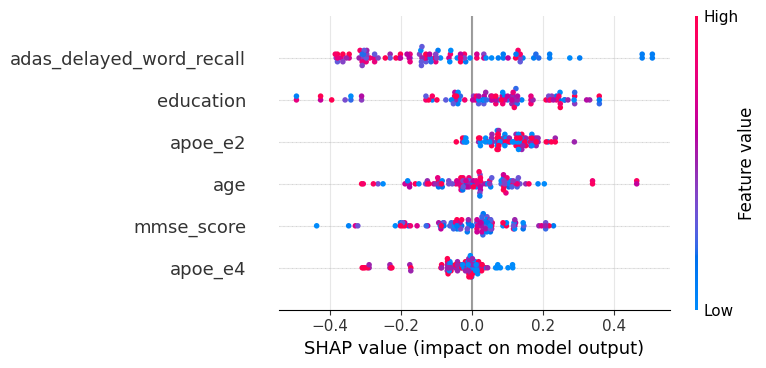

In [12]:
# Plot shap feature contribution plot for top 6 features
shap.initjs()
shap.summary_plot(np.array(list_shap_values), X.loc[list_test_sets],show=False,max_display=6)
plt.grid(alpha=0.3)

#save figure as png
#plt.savefig('shap_summary.png',bbox_inches='tight',dpi=300)